**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
    
# Warnings
import time
import sys
import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

import plotly.express as px

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, skew, kurtosis

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

print('start complete')

start complete


Here's some of the code you've written so far. Start by running it again.

In [2]:
# Code you have previously used to load data
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = '../input/train.csv'
home = pd.read_csv(iowa_file_path, index_col='Id')

# train data
iowa_file_path = '../input/train.csv'
train_data = pd.read_csv(iowa_file_path, index_col='Id')

# test data
test_data_path = '../input/test.csv'
test_data = pd.read_csv(test_data_path, index_col='Id')

home.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [3]:
px.imshow(train_data.corr(),
         template = 'seaborn',
         height = 750, width = 750)


#### Correlated pairs:
GarageCars - GarageArea / GrLivArea - TotRmsAbvGrd / Yearbuilt - GarageYrBlt


In [4]:
home_data = pd.concat([train_data.iloc[:, :-1], test_data], ignore_index=True)


In [5]:
count = pd.DataFrame(home_data.isnull().sum().sort_values(ascending = False), columns = ['NANs'])
count['Percent'] = count['NANs'].apply(lambda x: x/home_data.shape[0] * 100).round(3)
count['type']= home_data.dtypes
print(f"Data estimate:")
count.head(30)

Data estimate:


,NANs,Percent,type
PoolQC,2909,99.657,object
MiscFeature,2814,96.403,object
Alley,2721,93.217,object
Fence,2348,80.439,object
FireplaceQu,1420,48.647,object
LotFrontage,486,16.650,float64
GarageYrBlt,159,5.447,float64
GarageFinish,159,5.447,object
GarageQual,159,5.447,object
GarageCond,159,5.447,object


We can drop columns where more than 80% of the data is missing

In [6]:
# drop unnecessary rows
home_data.drop(['GarageYrBlt','TotRmsAbvGrd','GarageCars', 
                'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MoSold', 'YrSold'],axis = 1, inplace=True)
home_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Y,0,61,0,0,0,0,0,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,Y,298,0,0,0,0,0,0,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,Y,0,42,0,0,0,0,0,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Y,0,35,272,0,0,0,0,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,Y,192,84,0,0,0,0,0,WD,Normal


In [7]:
home_data['MSSubClass'] = home_data['MSSubClass'].astype('str')

In [8]:

cat_list = []
num_list = []

for var in home_data.columns:
    if home_data[var].dtype == 'object':
        cat_list.append(var)
    else:
        num_list.append(var)

# higly skewed categorical variables (>95%) are dropped

cat_drop_list = []

for var in cat_list:
    ratio = home_data[var].value_counts().iloc[0]/home_data.shape[0] * 100
    if ratio > 95:
        cat_drop_list.append(var)
        
print(cat_drop_list)
home_data.drop(cat_drop_list,axis = 1,inplace=True)

# for numerical variables that are highly skewed, try to make them Gaussian-like by box-cox transformation

num_trans_list = []

for var in num_list:
    ratio = home_data[var].value_counts().iloc[0]/home_data.shape[0] * 100
    if ratio > 95:
        num_trans_list.append(var)
        
print(num_trans_list)
for var in num_trans_list:
    home_data[var] = boxcox1p(home_data[var], boxcox_normmax(home_data[var] + 1))

['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating']
['LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']


In [9]:
home_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   LotShape       2919 non-null   object 
 5   LandContour    2919 non-null   object 
 6   LotConfig      2919 non-null   object 
 7   Neighborhood   2919 non-null   object 
 8   Condition1     2919 non-null   object 
 9   BldgType       2919 non-null   object 
 10  HouseStyle     2919 non-null   object 
 11  OverallQual    2919 non-null   int64  
 12  OverallCond    2919 non-null   int64  
 13  YearBuilt      2919 non-null   int64  
 14  YearRemodAdd   2919 non-null   int64  
 15  RoofStyle      2919 non-null   object 
 16  Exterior1st    2918 non-null   object 
 17  Exterior2nd    2918 non-null   object 
 18  MasVnrTy

In [10]:
train = train_data.drop(train_data[train_data['LotFrontage'] > 200].index)
train = train_data.drop(train_data[train_data['LotArea']> 100000].index)
train = train_data.drop(train_data[train_data['MasVnrArea'] > 1200].index)
train = train_data.drop(train_data[train_data['BsmtUnfSF'] > 2000].index)
train = train_data.drop(train_data[train_data['2ndFlrSF'] > 2000].index)
train = train_data.drop(train_data[train_data['GarageArea'] > 1130].index)
train = train_data.drop(train_data[train_data['WoodDeckSF'] > 600].index)
train = train_data.drop(train_data[train_data['OpenPorchSF'] > 400].index)
train = train_data.drop(train_data[train_data['BsmtFinSF1'] > 3000].index)
train = train_data.drop(train_data[train_data['TotalBsmtSF'] > 2000].index)
train = train_data.drop(train_data[train_data['GrLivArea'] > 2000].index)

In [11]:
count = pd.DataFrame(home_data.isnull().sum().sort_values(ascending = False), columns = ['NANs'])
count['Percent'] = count['NANs'].apply(lambda x: x/home_data.shape[0] * 100).round(3)
count['type']= home_data.dtypes
print(f"Data estimate:")
count.head(30)

Data estimate:


,NANs,Percent,type
FireplaceQu,1420,48.647,object
LotFrontage,486,16.650,float64
GarageCond,159,5.447,object
GarageQual,159,5.447,object
GarageFinish,159,5.447,object
GarageType,157,5.379,object
BsmtExposure,82,2.809,object
BsmtCond,82,2.809,object
BsmtQual,81,2.775,object
BsmtFinType2,80,2.741,object


In [12]:
# to sort missing data

num_list = []
cat_list = []

for var in count.index:
    if count['NANs'][var] > 0:
        if home_data[var].dtype != 'object':
            num_list.append(var)
        else:
            cat_list.append(var)
        
print(f"{num_list}, \n\n {cat_list}")

['LotFrontage', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'GarageArea'], 

 ['FireplaceQu', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MSZoning', 'Functional', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical', 'Exterior1st']


In [13]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}

ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
home_data[ord_col] = home_data[ord_col].fillna('NA')

for var in ord_col:
    home_data[var] = home_data[var].map(ordinal_map)
    
BsmtFin_col = ['BsmtFinType1','BsmtFinType2']
X=home_data[BsmtFin_col] = home_data[BsmtFin_col].fillna('NA')
for var in BsmtFin_col:
    home_data[var] = home_data[var].map(fintype_map)

home_data['BsmtExposure'] = home_data['BsmtExposure'].fillna('NA')
home_data['BsmtExposure'] = home_data['BsmtExposure'].map(expose_map)

In [14]:
neigh_lot = home_data.groupby('Neighborhood')['LotFrontage'].median().reset_index(name = 'LotFrontage_median') 
neigh_garage = home_data.groupby('Neighborhood')['GarageArea'].median().reset_index(name = 'GarageArea_median')

In [15]:
# lot frontage and garage area medians are correlated to neighborhood, so fill their nas using respective medians

home_data['LotFrontage'] = home_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
home_data['GarageArea'] = home_data.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.median()))

# to fill na using median for the rest of numerical variables

for var in ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]:
    home_data[var] = home_data[var].fillna(home_data[var].median())
    
count = pd.DataFrame(home_data.isnull().sum().sort_values(ascending = False), columns = ['NANs'])
count['Percent'] = count['NANs'].apply(lambda x: x/home_data.shape[0] * 100).round(3)
count['type']= home_data.dtypes
print(f"Data estimate:")
count.head(30)

Data estimate:


,NANs,Percent,type
GarageFinish,159,5.447,object
GarageType,157,5.379,object
MasVnrType,24,0.822,object
MSZoning,4,0.137,object
Functional,2,0.069,object
Electrical,1,0.034,object
Exterior1st,1,0.034,object
Exterior2nd,1,0.034,object
SaleType,1,0.034,object
BsmtHalfBath,0,0.000,float64


In [16]:
num_list = []
cat_list = []

for var in count.index:
    if count['NANs'][var] > 0:
        if home_data[var].dtype != 'object':
            num_list.append(var)
        else:
            cat_list.append(var)
        
print(f"{num_list}, \n\n {cat_list}")

[], 

 ['GarageFinish', 'GarageType', 'MasVnrType', 'MSZoning', 'Functional', 'Electrical', 'Exterior1st', 'Exterior2nd', 'SaleType']


In [17]:
# for categorical variables

home_data['GarageFinish'] = home_data['GarageFinish'].fillna('NA')
home_data['GarageType'] = home_data['GarageType'].fillna('NA')

# to fill missing values (categorical variables) with mode

cat_col = ['MasVnrType', 'MSZoning', 'Functional', 'Exterior2nd', 'Exterior1st', 'Electrical', 'SaleType']

for var in cat_col:
    home_data[var] = home_data[var].fillna(home_data[var].mode().iloc[0])
    
    count = pd.DataFrame(home_data.isnull().sum().sort_values(ascending = False), columns = ['NANs'])
count['Percent'] = count['NANs'].apply(lambda x: x/home_data.shape[0] * 100).round(3)
count['type']= home_data.dtypes
print(f"Data estimate:")
count.head(30)

Data estimate:


,NANs,Percent,type
MSSubClass,0,0.0,object
MSZoning,0,0.0,object
Electrical,0,0.0,object
1stFlrSF,0,0.0,int64
2ndFlrSF,0,0.0,int64
LowQualFinSF,0,0.0,float64
GrLivArea,0,0.0,int64
BsmtFullBath,0,0.0,float64
BsmtHalfBath,0,0.0,float64
FullBath,0,0.0,int64


In [18]:
# feature engineering (by domain knowledge)


home_data['TotalLot'] = home_data['LotFrontage'] + home_data['LotArea']
home_data['TotalBsmtFin'] = home_data['BsmtFinSF1'] + home_data['BsmtFinSF2']
home_data['TotalSF'] = home_data['TotalBsmtSF'] + home_data['2ndFlrSF'] + home_data['1stFlrSF']
home_data['TotalBath'] = home_data['FullBath'] + home_data['HalfBath'] * 0.5 + home_data['BsmtFullBath'] + home_data['BsmtHalfBath'] * 0.5
home_data['TotalPorch'] = home_data['OpenPorchSF'] + home_data['EnclosedPorch'] + home_data['ScreenPorch'] + home_data['WoodDeckSF']

drop_list = [
    'LotFrontage', 'LotArea',
    'BsmtFinSF1', 'BsmtFinSF2',
    'TotalBsmtSF', '2ndFlrSF','1stFlrSF',
    'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
    'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF'
]

home_data.drop(drop_list,axis=1, inplace=True)


In [19]:
# binary columns

bin_col = ['MasVnrArea','TotalPorch','PoolArea', 'GarageQual', 'BsmtQual']

for var in bin_col:
    col_name = var + '_bin'
    home_data[col_name] = home_data[var].apply(lambda x: 1 if x > 0 else 0)

In [20]:
X = pd.get_dummies(home_data)
y = train_data.iloc[:, -1]

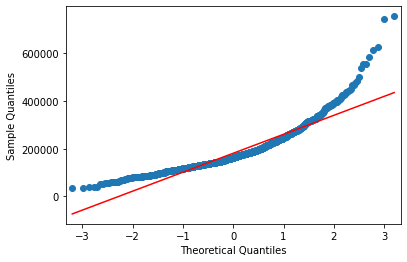

skewness: 1.88094
kurtosis: 6.50981


In [21]:
# to check the distribution of the target varaible
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import numpy as np

qqplot(y,line = 's')
plt.show()

print('skewness: %.5f' % (skew(y)))
print('kurtosis: %.5f' % (kurtosis(y)))

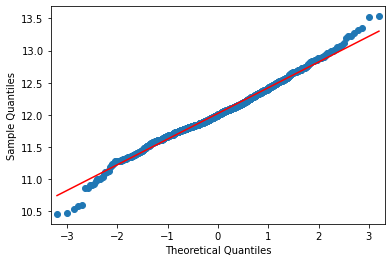

skewness: 0.12122
kurtosis: 0.80264


In [22]:
# the distribution is terribly off
# it is necessary to make y a bit Gaussian-like

qqplot(np.log1p(y),line = 's')
plt.show()

print('skewness: %.5f' % (skew(np.log1p(y))))
print('kurtosis: %.5f' % (kurtosis(np.log1p(y))))

In [23]:
y = y.apply(lambda x: np.log1p(x))

x = X.loc[train.index]
y = y.loc[train.index]

In [24]:
# lightgbm model

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold
from lightgbm import LGBMRegressor

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', LGBMRegressor(
    n_estimators = 1800,
    min_child_samples = 6,
    max_depth = 5,
    learning_rate = 0.01,
    lambda_l2 = 0.19,
    lambda_l1 = 0.04,
    feature_fraction = 0.25
)))

pipe_lgbm = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_lgbm, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.2818
STD: 0.0184
training time: 35.48


In [25]:
# catboost model

from catboost import CatBoostRegressor

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', CatBoostRegressor())) # the virgin model turned out to be the best one

pipe_cat = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_cat, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19
[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19
[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lamb

In [26]:
from sklearn.linear_model import RidgeCV

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', RidgeCV(cv=7)))

pipe_ridge = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_ridge, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.2758
STD: 0.0170
training time: 4.35


In [27]:
from sklearn.svm import SVR

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', SVR(epsilon=0.001,
                          gamma=0.028300001,
                          C=1)))

pipe_svr = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_svr, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.2801
STD: 0.0190
training time: 5.98


In [28]:
### stacking techqiues
# stacking solo is not superior to blending
# time-consuming

from mlxtend.regressor import StackingCVRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline 
stack_all = StackingCVRegressor(regressors= (pipe_lgbm, pipe_cat,
                                            pipe_en, pipe_svr),
                               meta_regressor = pipe_lgbm,
                               use_features_in_secondary=True,
                               )
start = time.time()
scores = cross_val_score(stack_all, x, y, scoring= 'neg_mean_absolute_error', cv = 3,
                        n_jobs = -1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

NameError: name 'pipe_en' is not defined

In [ ]:
def pipe_blend_fit_predict(home_data,c,e,f,g):
    pipe_lgbm.fit(x, y)
    pipe_cat.fit(x,y)
    pipe_ridge.fit(x,y)
    pipe_svr.fit(x,y)
    
    return ( 
            (c * pipe_lgbm.predict(home_data)) + 
            (f * pipe_cat.predict(home_data)) + 
            (g * pipe_ridge.predict(home_data).flatten()) + 
            (h * pipe_svr.predict(home_data)))

In [ ]:
test_df = home_data.loc[home.index]
pred = np.exp(pipe_blend_fit_predict(test_df, 0.2,0.1,0.1,0.1))

In [ ]:
output = pd.DataFrame({'Id': home.index,'SalePrice': pred})
output.to_csv('submission_1.csv', index=False)

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*